In [1]:
# Setup and Imports

print("--- Phase 0: Installing and Importing Libraries ---")

# --- 1: Install Required Libraries ---
!pip install pandas numpy scikit-learn matplotlib seaborn jupyter --quiet
!pip install combat --quiet  # Use the 'combat' library
!pip install shap --quiet
!pip install lifelines --quiet
!pip install gseapy --quiet

--- Phase 0: Installing and Importing Libraries ---


In [3]:
# 2: Import Libraries 
import pandas as pd
import numpy as np
import os
import tarfile
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [5]:
# Import the correct ComBat function
from combat.pycombat import pycombat

In [7]:
# Preprocessing & Normalization
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning

In [9]:
# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, matthews_corrcoef, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [11]:
# Explainable AI (XAI)
import shap

In [13]:
# Survival Analysis
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [15]:
print("Libraries installed and imported successfully.")

Libraries installed and imported successfully.


In [17]:
#  3: Define File Paths
DATA_DIR = "/Users/medhajha/Downloads/experiment/exp_2/"
MANIFEST_FILE = "/Users/medhajha/Downloads/gdc_manifest.2025-10-26.011239.txt"
SAMPLE_SHEET_FILE = "/Users/medhajha/Downloads/gdc_sample_sheet.2025-10-26.tsv"
CLINICAL_ARCHIVE_FILE = "/Users/medhajha/Downloads/clinical.cart.2025-10-26.tar.gz"

In [19]:
# Define base directory for clinical files
CLINICAL_DIR = os.path.dirname(CLINICAL_ARCHIVE_FILE)
CLINICAL_FILE_TSV = "clinical.tsv"
FOLLOWUP_FILE_TSV = "follow_up.tsv"
CLINICAL_FILE_TSV_PATH = os.path.join(CLINICAL_DIR, CLINICAL_FILE_TSV)
FOLLOWUP_FILE_TSV_PATH = os.path.join(CLINICAL_DIR, FOLLOWUP_FILE_TSV)

print(f"Data directory set to: {DATA_DIR}")
print("--- Phase 0 Complete ---")

Data directory set to: /Users/medhajha/Downloads/experiment/exp_2/
--- Phase 0 Complete ---


In [23]:
print("\n--- Phase 1: Loading Metadata and Gene Counts ---")


--- Phase 1: Loading Metadata and Gene Counts ---


In [25]:
if not os.path.exists(CLINICAL_FILE_TSV_PATH) or not os.path.exists(FOLLOWUP_FILE_TSV_PATH):
    print(f"Extracting {CLINICAL_ARCHIVE_FILE}...")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=DeprecationWarning)
        with tarfile.open(CLINICAL_ARCHIVE_FILE, "r:gz") as tar:
            tar.extractall(path=CLINICAL_DIR)
            print(f"Successfully extracted clinical files to {CLINICAL_DIR}")
else:
    print("Clinical files already extracted.")

Clinical files already extracted.


In [27]:
print("Loading metadata...")
manifest_df = pd.read_csv(MANIFEST_FILE, sep="\t")
sample_sheet_df = pd.read_csv(SAMPLE_SHEET_FILE, sep="\t")
manifest_df = manifest_df.rename(columns={'id': 'Manifest_File_ID'})
metadata_df = pd.merge(manifest_df, sample_sheet_df, left_on="filename", right_on="File Name", how="left")
print("Metadata merge successful!")

Loading metadata...
Metadata merge successful!


In [29]:
def get_label(row):
    if pd.notna(row["Tissue Type"]) and "Normal" in row["Tissue Type"]:
        return "Normal"
    elif row["Project ID"] == "TCGA-BRCA":
        return "BRCA"
    elif row["Project ID"] == "TCGA-OV":
        return "OV"
    elif row["Project ID"] in ["TCGA-LUAD", "TCGA-LUSC"]:
        return "LUNG"
    else:
        return "Other"

metadata_df["label"] = metadata_df.apply(get_label, axis=1)
metadata_df["batch"] = metadata_df["Project ID"]
metadata_df = metadata_df[metadata_df["label"] != "Other"].copy()
metadata_df = metadata_df.set_index("Manifest_File_ID")
metadata_df.index.name = "File ID"
print(f"Created metadata for {len(metadata_df)} samples.")
print(metadata_df["label"].value_counts())

Created metadata for 2260 samples.
label
BRCA      1118
LUNG       541
OV         429
Normal     172
Name: count, dtype: int64


In [31]:
count_data_list = []
sample_ids_in_order = []
print("Loading and combining count files... (This may take several minutes)")

Loading and combining count files... (This may take several minutes)


In [39]:
# ==============================================================================
# Phase 1: Data Loading & Metadata Preparation (Corrected)
# ==============================================================================
print("\n--- Phase 1: Loading Metadata and Gene Counts ---")

# --- 1.1: Extract Clinical Data ---
# (Assuming this was already run in Phase 0, but good to have)
if not os.path.exists(CLINICAL_FILE_TSV_PATH) or not os.path.exists(FOLLOWUP_FILE_TSV_PATH):
    print(f"Extracting {CLINICAL_ARCHIVE_FILE}...")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=DeprecationWarning)
        with tarfile.open(CLINICAL_ARCHIVE_FILE, "r:gz") as tar:
            tar.extractall(path=CLINICAL_DIR)
            print(f"Successfully extracted clinical files to {CLINICAL_DIR}")
else:
    print("Clinical files already extracted.")

# --- 1.2: Load Metadata Files ---
print("Loading metadata...")
manifest_df = pd.read_csv(MANIFEST_FILE, sep="\t")
sample_sheet_df = pd.read_csv(SAMPLE_SHEET_FILE, sep="\t")
manifest_df = manifest_df.rename(columns={'id': 'Manifest_File_ID'})
metadata_df = pd.merge(manifest_df, sample_sheet_df, left_on="filename", right_on="File Name", how="left")
print("Metadata merge successful!")

# --- 1.3: Create Labels ---
def get_label(row):
    if pd.notna(row["Tissue Type"]) and "Normal" in row["Tissue Type"]:
        return "Normal"
    elif row["Project ID"] == "TCGA-BRCA":
        return "BRCA"
    elif row["Project ID"] == "TCGA-OV":
        return "OV"
    elif row["Project ID"] in ["TCGA-LUAD", "TCGA-LUSC"]:
        return "LUNG"
    else:
        return "Other"

metadata_df["label"] = metadata_df.apply(get_label, axis=1)
metadata_df["batch"] = metadata_df["Project ID"]
metadata_df = metadata_df[metadata_df["label"] != "Other"].copy()
metadata_df = metadata_df.set_index("Manifest_File_ID")
metadata_df.index.name = "File ID"
print(f"Created metadata for {len(metadata_df)} samples.")
print(metadata_df["label"].value_counts())

# --- 1.4: Combine All Count Files ---
count_data_list = []
sample_ids_in_order = []
print("Loading and combining count files... (This may take several minutes)")

# Pre-run Check
first_file_id = metadata_df.index[0]
expected_folder_path = os.path.join(DATA_DIR, first_file_id)
if not os.path.isdir(expected_folder_path):
    print(f"--- !!! ERROR: DATA_DIR PATH IS WRONG !!! ---")
    raise FileNotFoundError(f"Could not find data directory: {expected_folder_path}")

# *** THIS IS THE FIX: Initialize counters ***
processed_files = 0
skipped_files = 0
# *****************************************

for file_id in metadata_df.index:
    folder_path = os.path.join(DATA_DIR, file_id)
    if not os.path.isdir(folder_path):
         print(f"Warning: Folder not found for {file_id}. Skipping.")
         skipped_files += 1
         continue

    file_path_glob = os.path.join(folder_path, "*augmented_star_gene_counts.tsv")
    found_files = glob(file_path_glob)
    if not found_files:
         print(f"Warning: No 'augmented_star_gene_counts.tsv' file found in folder {file_id}. Skipping.")
         skipped_files += 1
         continue
    file_path = found_files[0]

    try:
        # Corrected pd.read_csv call
        sample_df_full = pd.read_csv(file_path, sep="\t", comment='#', header=0)

        if 'gene_id' not in sample_df_full.columns or 'unstranded' not in sample_df_full.columns:
             print(f"Warning: Expected columns ('gene_id', 'unstranded') not found in {file_id}. Skipping.")
             skipped_files +=1
             continue

        sample_df = sample_df_full[['gene_id', 'unstranded']].copy()
        sample_df = sample_df.rename(columns={'unstranded': 'count'})
        sample_df = sample_df[~sample_df['gene_id'].str.startswith('N_', na=False)]

        if not sample_df['gene_id'].astype(str).str.startswith('ENSG', na=False).any():
            print(f"Warning: No Ensembl IDs (ENSG*) found in {file_id} after filtering. Skipping.")
            skipped_files += 1
            continue

        sample_df = sample_df.set_index("gene_id")
        sample_df.columns = [file_id]
        count_data_list.append(sample_df)
        sample_ids_in_order.append(file_id)
        processed_files += 1

    except Exception as e:
        print(f"Error processing file {file_id} at path {file_path}: {e}")
        skipped_files += 1

if not count_data_list:
    raise ValueError("No count files were successfully read.")

print("\nMerging all samples into one dataframe...")
counts_df = pd.concat(count_data_list, axis=1)
metadata_df = metadata_df.loc[sample_ids_in_order]
print("Count data loading complete.")
print(f"Successfully processed: {processed_files} files.")
print(f"Skipped/Errored: {skipped_files} files.")
print(f"Final Count matrix shape: {counts_df.shape}")
print(f"Final Metadata shape: {metadata_df.shape}")
print("--- Phase 1 Complete ---")


--- Phase 1: Loading Metadata and Gene Counts ---
Clinical files already extracted.
Loading metadata...
Metadata merge successful!
Created metadata for 2260 samples.
label
BRCA      1118
LUNG       541
OV         429
Normal     172
Name: count, dtype: int64
Loading and combining count files... (This may take several minutes)

Merging all samples into one dataframe...
Count data loading complete.
Successfully processed: 2260 files.
Skipped/Errored: 0 files.
Final Count matrix shape: (60660, 2260)
Final Metadata shape: (2260, 17)
--- Phase 1 Complete ---


In [41]:
print("\n--- Phase 2: Normalization & Batch Correction ---")


--- Phase 2: Normalization & Batch Correction ---


In [43]:
counts_df.index = counts_df.index.str.split('.').str[0]
print(f"Genes before deduplication: {len(counts_df)}")
counts_df = counts_df.groupby(counts_df.index).sum()
print(f"Genes after deduplication: {len(counts_df)}")

Genes before deduplication: 60660
Genes after deduplication: 60616


In [45]:
print(f"\nGenes before filtering: {len(counts_df)}")
min_counts = 10
min_samples_pct = 0.1
min_samples = max(1, int(counts_df.shape[1] * min_samples_pct))
keep_genes = (counts_df >= min_counts).sum(axis=1) >= min_samples
counts_df = counts_df.loc[keep_genes]
print(f"Genes after filtering: {len(counts_df)}")


Genes before filtering: 60616
Genes after filtering: 27913


In [47]:
#  2.3: Calculate log2(CPM+1)
def calculate_cpm(df):
    total_counts = df.sum(axis=0).replace(0, 1)
    cpm_df = df.apply(lambda x: (x / total_counts[x.name]) * 1_000_000, axis=0)
    return cpm_df

print("\nCalculating CPM...")
cpm_df = calculate_cpm(counts_df)
print("Calculating log2(CPM+1)...")
log_cpm_df = np.log2(cpm_df + 1)


Calculating CPM...
Calculating log2(CPM+1)...


In [49]:
batches = metadata_df['batch'].tolist()
print("\nRunning ComBat for batch correction...")
log_cpm_df = log_cpm_df.fillna(0)
# Correct ComBat call
log_cpm_combat_df = pycombat(log_cpm_df.astype(float), batches)
log_cpm_combat_df = pd.DataFrame(log_cpm_combat_df, index=log_cpm_df.index, columns=log_cpm_df.columns)
print("Batch correction complete.")


Running ComBat for batch correction...
Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Batch correction complete.


In [51]:
print("\nApplying Quantile Normalization...")
qt = QuantileTransformer(output_distribution='normal', random_state=42)
data_transposed = log_cpm_combat_df.T
data_quantiled = qt.fit_transform(data_transposed)
final_data_df = pd.DataFrame(data_quantiled.T, index=log_cpm_combat_df.index, columns=log_cpm_combat_df.columns)
print(f"Final data matrix shape: {final_data_df.shape}")


Applying Quantile Normalization...
Final data matrix shape: (27913, 2260)



Generating PCA plots...


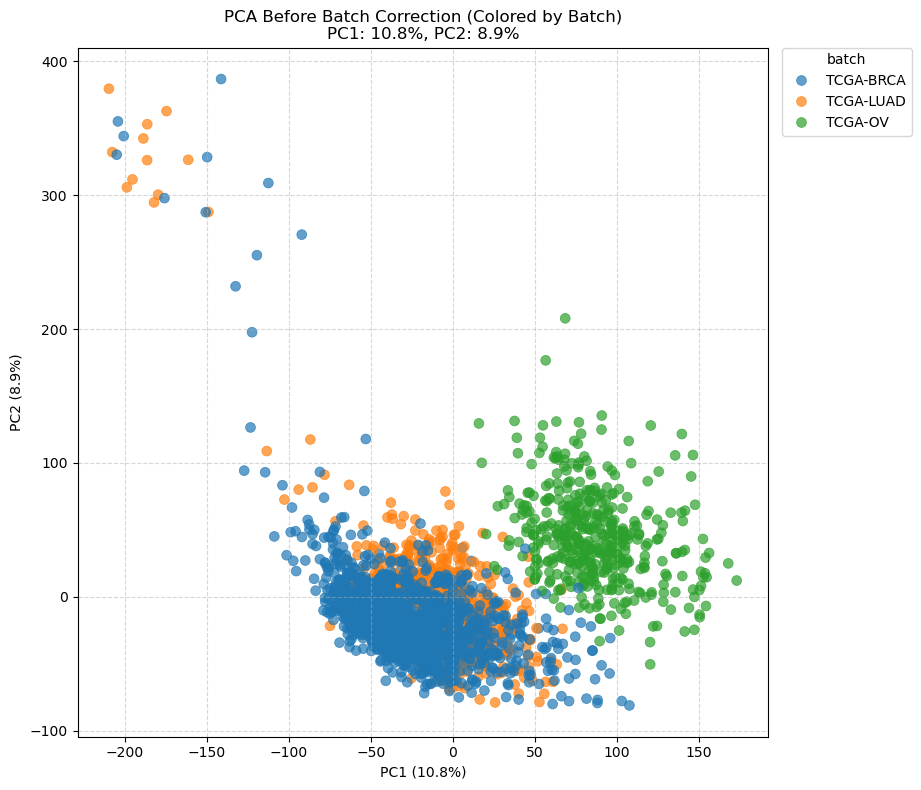

Plotting PCA before batch correction (colored by batch)...
Plotting PCA after ComBat (colored by batch)...


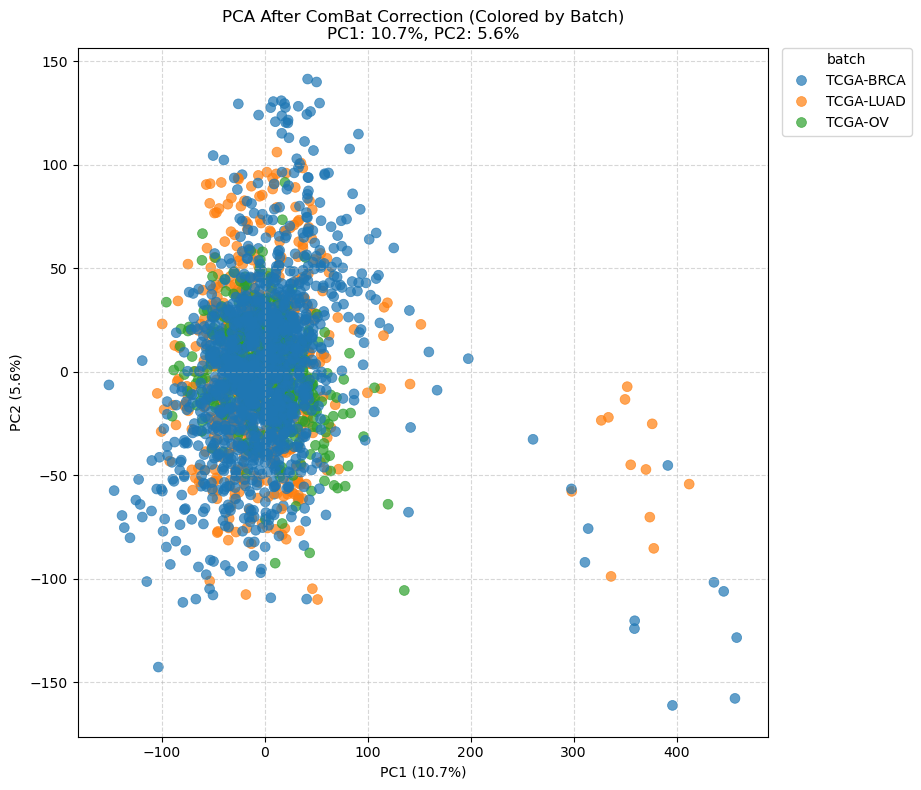

Plotting PCA before batch correction (colored by batch)...
Plotting PCA after ComBat (colored by class)...


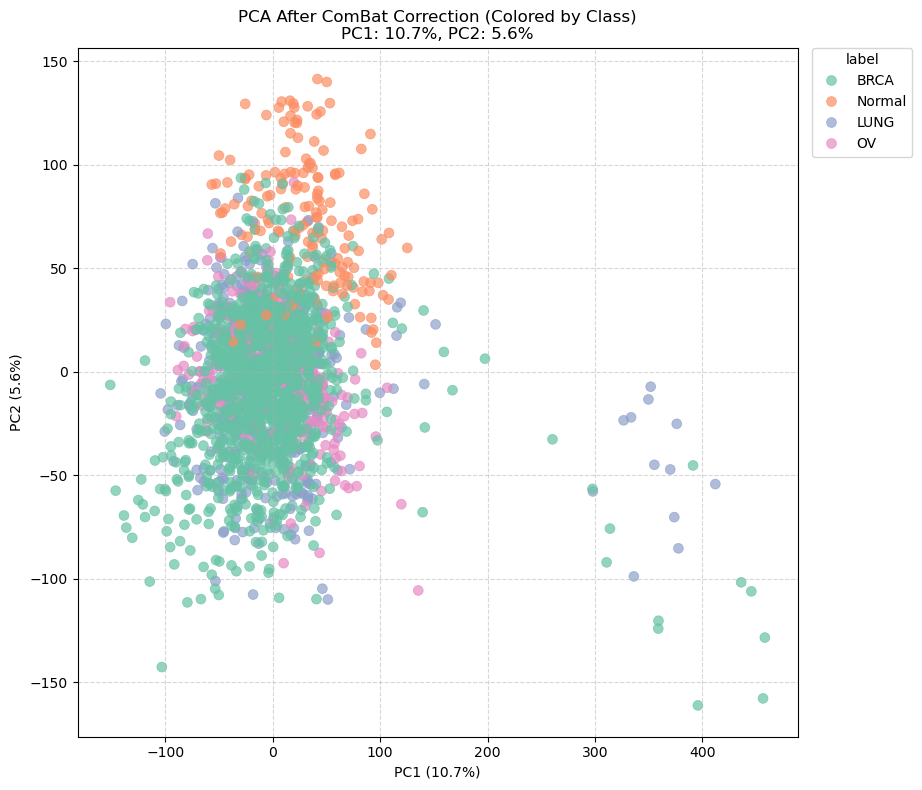

Plotting PCA before batch correction (colored by batch)...
--- Phase 2 Complete ---


In [53]:
print("\nGenerating PCA plots...")
X_log_cpm = log_cpm_df.T
X_combat = log_cpm_combat_df.T
plot_labels = metadata_df['label']
plot_batches = metadata_df['batch']
def plot_pca(data, title, color_by, palette='viridis'):
    data_numeric = data.apply(pd.to_numeric, errors='coerce').fillna(0)
    scaler_pca = StandardScaler()
    data_scaled = scaler_pca.fit_transform(data_numeric)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_scaled)
    pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=data_numeric.index)
    pc_df['Color'] = color_by.loc[pc_df.index].values
    explained_var = pca.explained_variance_ratio_

    plt.figure(figsize=(11, 8))
    sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='Color', palette=palette, s=50, alpha=0.7, edgecolor=None)
    plt.title(f"{title}\nPC1: {explained_var[0]:.1%}, PC2: {explained_var[1]:.1%}")
    plt.xlabel(f"PC1 ({explained_var[0]:.1%})")
    plt.ylabel(f"PC2 ({explained_var[1]:.1%})")
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels) > 15:
        plt.legend(handles[:15], labels[:15], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., title=color_by.name)
    else:
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., title=color_by.name)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
    print("Plotting PCA before batch correction (colored by batch)...")
plot_pca(X_log_cpm, "PCA Before Batch Correction (Colored by Batch)", plot_batches, palette='tab10')
print("Plotting PCA after ComBat (colored by batch)...")
plot_pca(X_combat, "PCA After ComBat Correction (Colored by Batch)", plot_batches, palette='tab10')
print("Plotting PCA after ComBat (colored by class)...")
plot_pca(X_combat, "PCA After ComBat Correction (Colored by Class)", plot_labels, palette='Set2')
print("--- Phase 2 Complete ---")

In [55]:
print("\n--- Phase 3: Machine Learning Model Selection ---")


--- Phase 3: Machine Learning Model Selection ---


In [57]:
X = final_data_df.T
y_strings = metadata_df['label']

In [59]:
label_map = {label: i for i, label in enumerate(y_strings.unique())}
y = y_strings.map(label_map)
class_names_in_order = [label for label, i in sorted(label_map.items(), key=lambda item: item[1])]
print(f"Label mapping created: {label_map}")

Label mapping created: {'BRCA': 0, 'Normal': 1, 'LUNG': 2, 'OV': 3}


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print(f"Splitting data: Training set {X_train.shape}, Test set {X_test.shape}")

Splitting data: Training set (1808, 27913), Test set (452, 27913)


In [63]:
pipelines = {
    "KNN": Pipeline([('scaler', StandardScaler()), ('model', KNeighborsClassifier(n_neighbors=5))]),
    "RF": Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'))]),
    "MLP": Pipeline([('scaler', StandardScaler()), ('model', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True, n_iter_no_change=20, validation_fraction=0.1))])
}

In [65]:
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'mcc': make_scorer(matthews_corrcoef)
}

cv_results = {}
print("\nRunning 5-fold cross-validation...")
for model_name, pipe in pipelines.items():
    print(f"--- Training {model_name} ---")
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        scores = cross_validate(pipe, X_train, y_train, cv=cv_splitter, scoring=scoring_metrics, n_jobs=-1, error_score='raise')
    cv_results[model_name] = scores
    print(f"Finished {model_name}.")


Running 5-fold cross-validation...
--- Training KNN ---
Finished KNN.
--- Training RF ---
Finished RF.
--- Training MLP ---
Finished MLP.


In [67]:
print("\n--- Cross-Validation Results ---")
best_mcc = -1.0
BEST_MODEL_NAME = ""
cv_summary = []

for model_name, scores in cv_results.items():
    mean_acc = np.mean(scores['test_accuracy'])
    mean_f1 = np.mean(scores['test_f1_weighted'])
    mean_mcc = np.mean(scores['test_mcc'])
    cv_summary.append({'Model': model_name, 'Mean Accuracy': mean_acc, 'Mean F1-Weighted': mean_f1, 'Mean MCC': mean_mcc})
    if mean_mcc > best_mcc:
        best_mcc = mean_mcc
        BEST_MODEL_NAME = model_name

cv_summary_df = pd.DataFrame(cv_summary).set_index('Model').round(4)
print("\nCross-Validation Summary:")
print(cv_summary_df)
print(f"\n--- Best Model Selected: {BEST_MODEL_NAME} (MCC: {best_mcc:.4f}) ---")
best_pipeline = pipelines[BEST_MODEL_NAME]
print("--- Phase 3 Complete ---")


--- Cross-Validation Results ---

Cross-Validation Summary:
       Mean Accuracy  Mean F1-Weighted  Mean MCC
Model                                           
KNN           0.8827            0.8731    0.8245
RF            0.9917            0.9916    0.9874
MLP           0.9834            0.9836    0.9750

--- Best Model Selected: RF (MCC: 0.9874) ---
--- Phase 3 Complete ---


In [69]:
print(f"\n--- Phase 4: Final Evaluation & XAI for {BEST_MODEL_NAME} ---")


--- Phase 4: Final Evaluation & XAI for RF ---


In [71]:
print(f"Training final {BEST_MODEL_NAME} model on all training data...")
best_pipeline.fit(X_train, y_train)
print("Final model training complete.")

Training final RF model on all training data...
Final model training complete.


In [73]:
print("\nEvaluating final model on the held-out TEST set...")
y_pred = best_pipeline.predict(X_test)


Evaluating final model on the held-out TEST set...


In [75]:
print("\n--- Test Set Performance ---")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names_in_order))
final_mcc = matthews_corrcoef(y_test, y_pred)
print(f"Test Set MCC: {final_mcc:.4f}")


--- Test Set Performance ---
Classification Report:
              precision    recall  f1-score   support

        BRCA       0.99      1.00      0.99       224
      Normal       0.94      0.91      0.93        34
        LUNG       0.99      0.99      0.99       108
          OV       1.00      1.00      1.00        86

    accuracy                           0.99       452
   macro avg       0.98      0.97      0.98       452
weighted avg       0.99      0.99      0.99       452

Test Set MCC: 0.9831


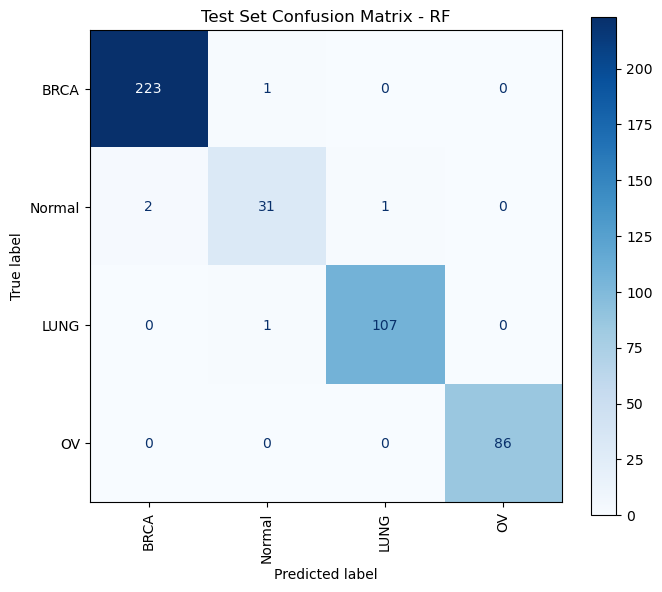

In [77]:
cm = confusion_matrix(y_test, y_pred, labels=best_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_in_order)
fig, ax = plt.subplots(figsize=(7, 6))
disp.plot(cmap='Blues', xticks_rotation='vertical', ax=ax, values_format='d')
plt.title(f"Test Set Confusion Matrix - {BEST_MODEL_NAME}")
plt.tight_layout()
plt.show()

In [83]:
print("\nCalculating SHAP values...")
model = best_pipeline.named_steps['model']
scaler = best_pipeline.named_steps['scaler']
X_train_scaled_shap = scaler.transform(X_train)
X_test_scaled_shap = scaler.transform(X_test)
feature_names = X_train.columns.tolist()
X_test_scaled_shap_df = pd.DataFrame(X_test_scaled_shap, index=X_test.index, columns=feature_names)
X_test_scaled_shap_array = X_test_scaled_shap_df.values
shap_values_raw = None
if BEST_MODEL_NAME == "RF":
    print("Using TreeExplainer for SHAP...")
    explainer = shap.TreeExplainer(model)
    shap_values_raw = explainer.shap_values(X_test_scaled_shap_array)
else:
    print(f"Using KernelExplainer for SHAP (this is slow)...")
    background_data = shap.sample(X_train_scaled_shap, 100)
    explainer = shap.KernelExplainer(model.predict_proba, background_data)
    shap_values_raw = explainer.shap_values(X_test_scaled_shap_array[:50], nsamples=100) # On 50 samples for speed
    # Adjust X_test_scaled_shap_array and _df if using KernelExplainer on a subset
    if X_test_scaled_shap_array.shape[0] != shap_values_raw[0].shape[0]:
         X_test_scaled_shap_array = X_test_scaled_shap_array[:50]
         X_test_scaled_shap_df = X_test_scaled_shap_df.iloc[:50]
print("SHAP values calculated.")


Calculating SHAP values...
Using TreeExplainer for SHAP...
SHAP values calculated.


In [85]:
shap_values = None
if shap_values_raw is not None and BEST_MODEL_NAME == "RF":
    print("Re-stacking SHAP values for summary plots...")
    try:
        shap_values_stacked = np.array(shap_values_raw)
        n_classes = shap_values_stacked.shape[2]
        shap_values_by_class = []
        for i in range(n_classes):
            shap_values_by_class.append(shap_values_stacked[:, :, i])
        shap_values = shap_values_by_class
        print(f"Re-stacked into a list of {len(shap_values)} arrays.")
    except Exception as e:
        print(f"Error during SHAP re-stacking: {e}")
        shap_values = shap_values_raw
elif shap_values_raw is not None:
    shap_values = shap_values_raw

Re-stacking SHAP values for summary plots...
Re-stacked into a list of 4 arrays.


Generating SHAP Global Bar Plot...


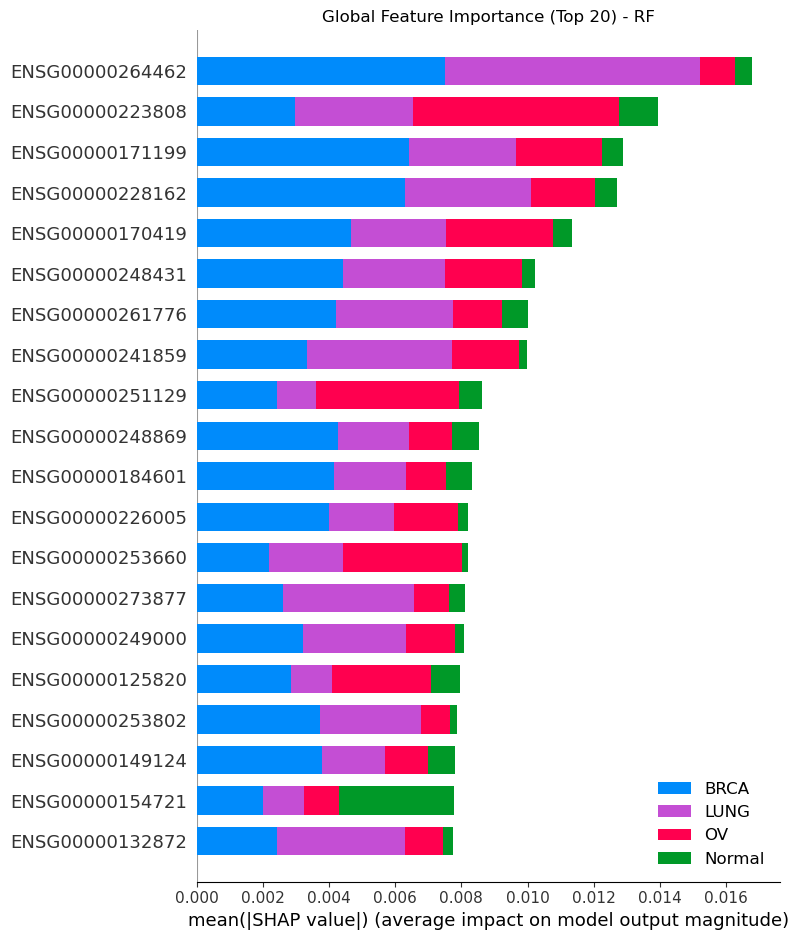


Generating SHAP Summary Plots (Beeswarm)...
Plotting SHAP for class: BRCA


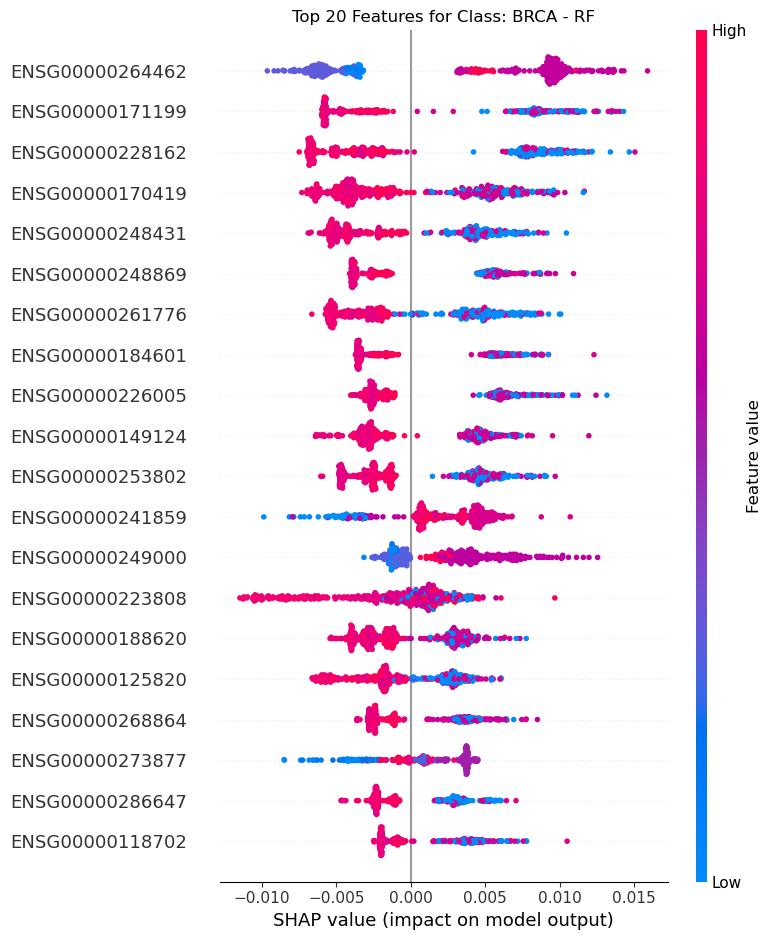

Plotting SHAP for class: Normal


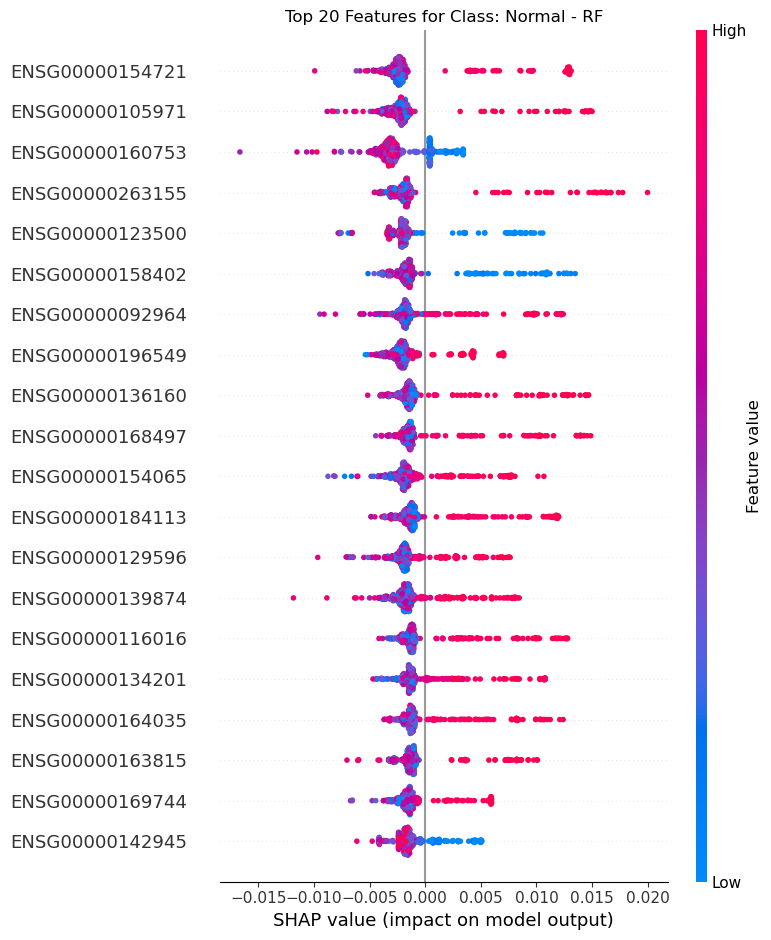

Plotting SHAP for class: LUNG


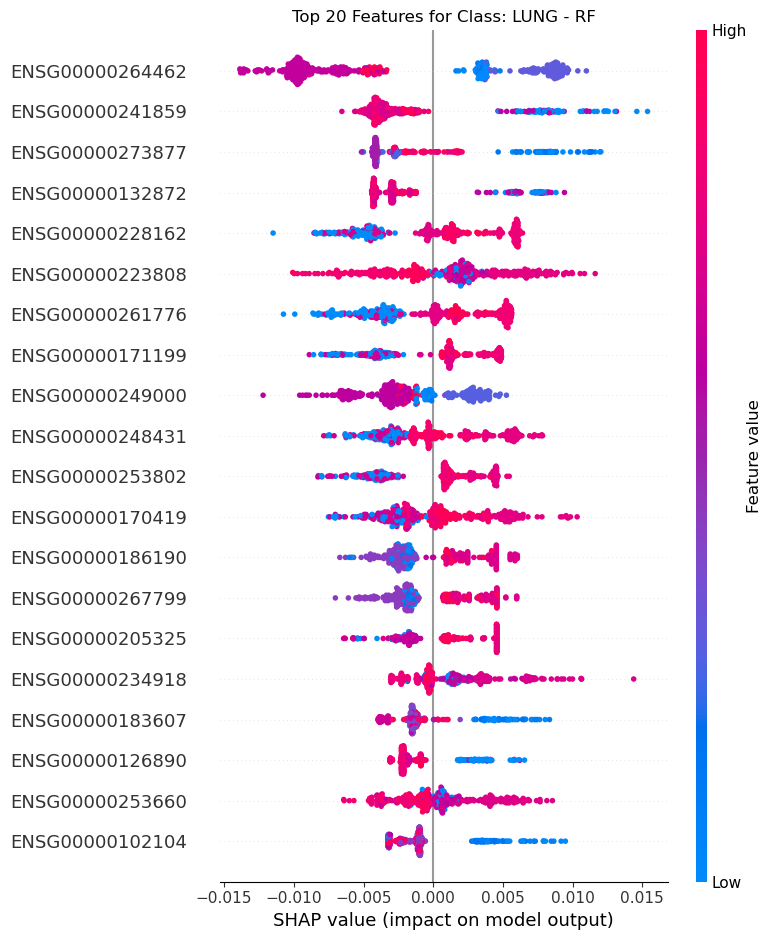

Plotting SHAP for class: OV


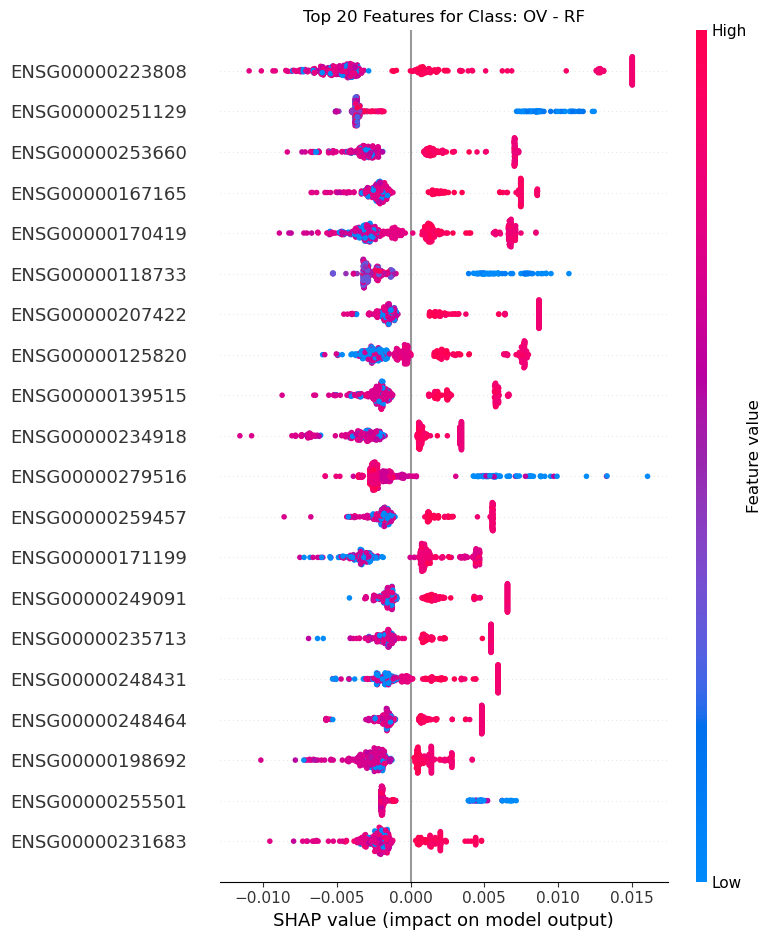


Top 20 important genes based on SHAP:
['ENSG00000264462', 'ENSG00000223808', 'ENSG00000171199', 'ENSG00000228162', 'ENSG00000170419', 'ENSG00000248431', 'ENSG00000261776', 'ENSG00000241859', 'ENSG00000251129', 'ENSG00000248869', 'ENSG00000184601', 'ENSG00000226005', 'ENSG00000253660', 'ENSG00000273877', 'ENSG00000249000', 'ENSG00000125820', 'ENSG00000253802', 'ENSG00000149124', 'ENSG00000154721', 'ENSG00000132872']
--- Phase 4 Complete ---


In [92]:
if shap_values is not None and isinstance(shap_values, list) and len(shap_values) == len(class_names_in_order):
    print("Generating SHAP Global Bar Plot...")
    plt.figure()
    shap.summary_plot(shap_values, X_test_scaled_shap_df, plot_type="bar",
                      class_names=class_names_in_order,
                      feature_names=feature_names,
                      max_display=20,
                      show=False)
    plt.title(f"Global Feature Importance (Top 20) - {BEST_MODEL_NAME}")
    plt.tight_layout()
    plt.show()

    print("\nGenerating SHAP Summary Plots (Beeswarm)...")
    shap_sum_list = []
    for i, class_name in enumerate(class_names_in_order):
        print(f"Plotting SHAP for class: {class_name}")
        plt.figure()
        
        shap_vals = shap_values[i]
        # Robust check for extra column
        if shap_vals.shape[1] > X_test_scaled_shap_array.shape[1]:
            print(f"  Adjusting SHAP shape from {shap_vals.shape[1]} to {X_test_scaled_shap_array.shape[1]} features.")
            shap_vals = shap_vals[:, :X_test_scaled_shap_array.shape[1]]
        elif shap_vals.shape[1] != X_test_scaled_shap_array.shape[1]:
            raise ValueError(f"Feature dimension mismatch for class {class_name}.")
        
        shap_sum_list.append(shap_vals)
        
        shap.summary_plot(
            shap_vals, X_test_scaled_shap_array,
            feature_names=feature_names,
            max_display=20,
            show=False
        )
        plt.title(f"Top 20 Features for Class: {class_name} - {BEST_MODEL_NAME}")
        plt.tight_layout()
        plt.show()
        # Get Top Genes List
    if shap_sum_list:
        shap_sum = np.abs(shap_sum_list[0]).mean(0)
        for i in range(1, len(shap_sum_list)):
            shap_sum += np.abs(shap_sum_list[i]).mean(0)
            
        shap_genes_df = pd.DataFrame({'mean_abs_shap': shap_sum}, index=feature_names)
        shap_genes_df = shap_genes_df.sort_values('mean_abs_shap', ascending=False)
        top_20_genes = shap_genes_df.head(20).index.tolist()
        print(f"\nTop 20 important genes based on SHAP:\n{top_20_genes}")
    else:
        print("Could not generate top genes list.")
        top_20_genes = []
else:
    print("SHAP values could not be calculated/re-stacked. Skipping plots.")
    top_20_genes = []

print("--- Phase 4 Complete ---")
        

In [94]:
print("\n--- Phase 5: Biological Interpretation ---")


--- Phase 5: Biological Interpretation ---


In [96]:
id_to_name_map = {}
if 'top_20_genes' in locals() and top_20_genes:
    print("Building gene ID-to-Name map...")
    try:
        first_file_id = metadata_df.index[0]
        folder_path = os.path.join(DATA_DIR, first_file_id)
        file_path_glob = os.path.join(folder_path, "*.tsv")
        file_path = glob(file_path_glob)[0]
        gene_map_df = pd.read_csv(file_path, sep="\t", comment='#', header=0, usecols=['gene_id', 'gene_name'])
        gene_map_df = gene_map_df[~gene_map_df['gene_id'].str.startswith('N_', na=False)]
        gene_map_df['stripped_id'] = gene_map_df['gene_id'].str.split('.').str[0]
        id_to_name_map = gene_map_df.set_index('stripped_id')['gene_name'].to_dict()
        print("Gene map created successfully.")
        top_20_gene_names = [id_to_name_map.get(gid, gid) for gid in top_20_genes]
        top_genes_df = pd.DataFrame({'Ensembl_ID': top_20_genes, 'Gene_Name': top_20_gene_names})
        print("\n--- Top 20 Most Important Genes (from SHAP) ---")
        print(top_genes_df)
    except Exception as e:
        print(f"Error creating gene map: {e}")
        top_20_gene_names = top_20_genes
else:
    print("Skipping gene mapping (no top genes identified).")
    top_20_gene_names = []

Building gene ID-to-Name map...
Gene map created successfully.

--- Top 20 Most Important Genes (from SHAP) ---
         Ensembl_ID   Gene_Name
0   ENSG00000264462   MIR3648-2
1   ENSG00000223808  AC044784.1
2   ENSG00000171199       OPRPN
3   ENSG00000228162  AC097713.1
4   ENSG00000170419      VSTM2A
5   ENSG00000248431  AC021134.1
6   ENSG00000261776  AC079414.2
7   ENSG00000241859      ANOS2P
8   ENSG00000251129   LINC02506
9   ENSG00000248869   LINC02511
10  ENSG00000184601   C14orf180
11  ENSG00000226005   LINC02660
12  ENSG00000253660  AC008464.1
13  ENSG00000273877  AC236972.3
14  ENSG00000249000  AC093722.1
15  ENSG00000125820      NKX2-2
16  ENSG00000253802      SIRLNT
17  ENSG00000149124       GLYAT
18  ENSG00000154721        JAM2
19  ENSG00000132872        SYT4



Generating Biomarker Box Plots for Top 5 SHAP genes...


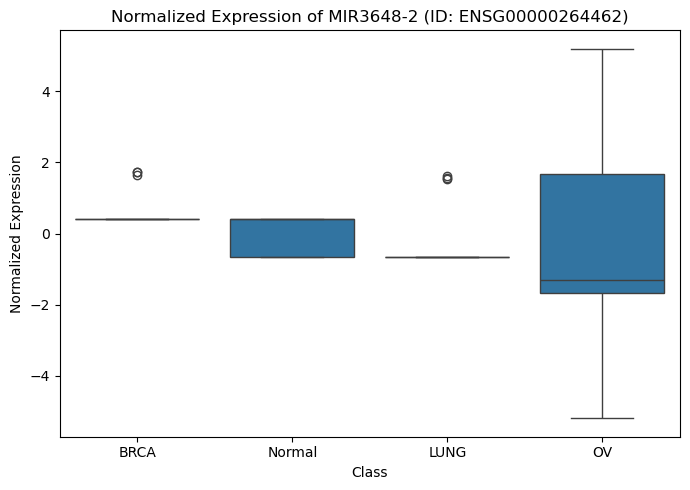

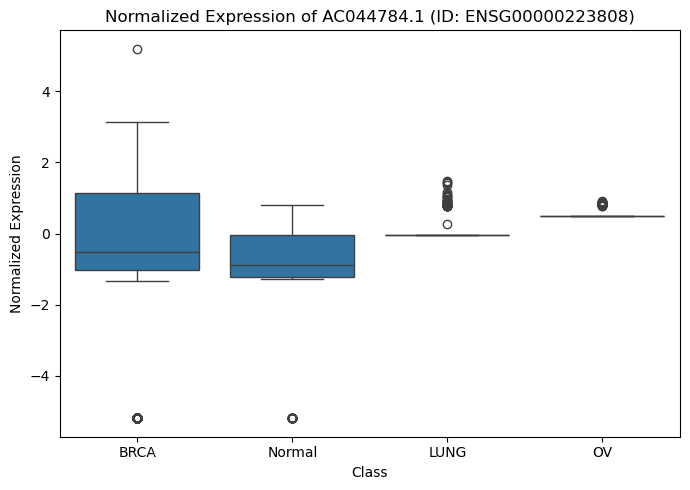

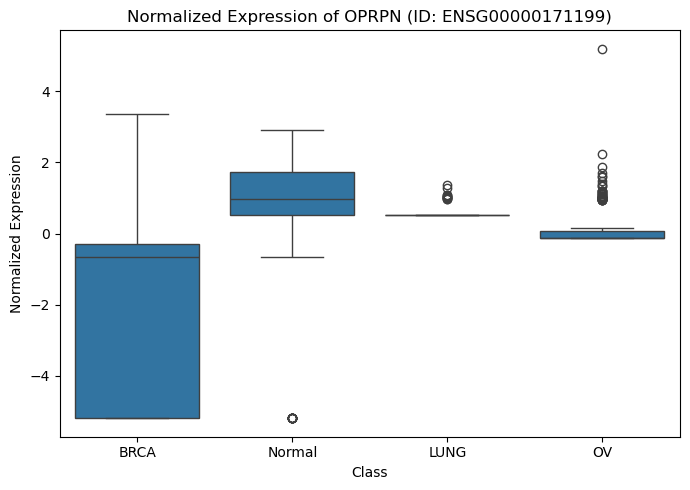

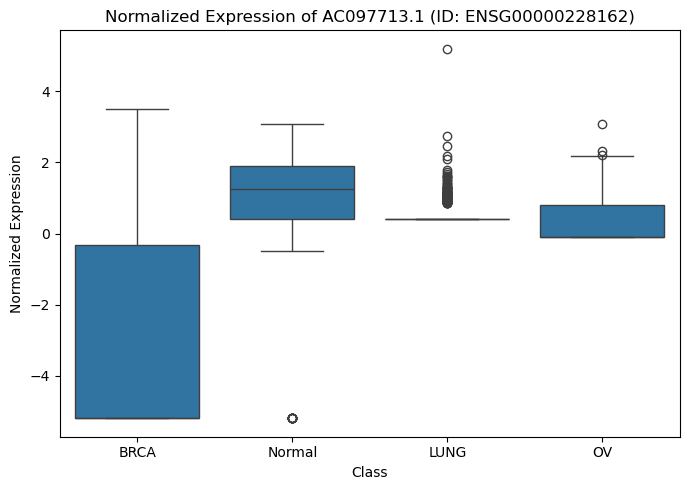

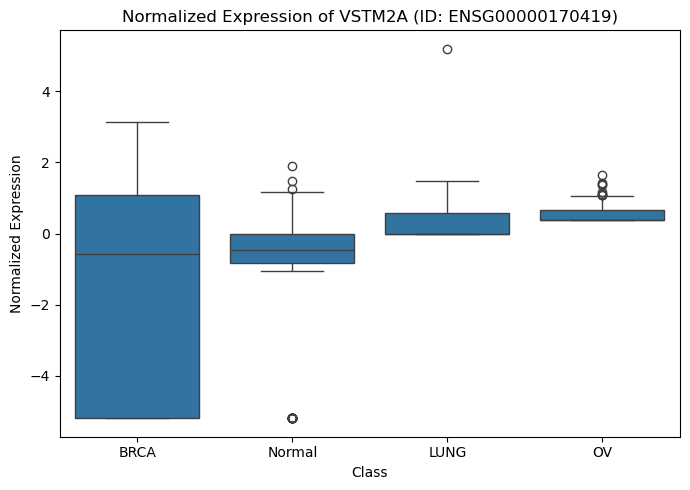

In [98]:
if 'top_20_genes' in locals() and top_20_genes:
    plot_df_expr = final_data_df.T.copy()
    plot_df_expr['label'] = metadata_df['label'].values
    print("\nGenerating Biomarker Box Plots for Top 5 SHAP genes...")
    plot_order = class_names_in_order
    for (gene_id, gene_name) in zip(top_20_genes[:5], top_20_gene_names[:5]):
        if gene_id in plot_df_expr.columns:
            plt.figure(figsize=(7, 5))
            sns.boxplot(data=plot_df_expr, x='label', y=gene_id, order=plot_order)
            plt.title(f"Normalized Expression of {gene_name} (ID: {gene_id})")
            plt.xlabel("Class")
            plt.ylabel("Normalized Expression")
            plt.tight_layout()
            plt.show()
else:
    print("Skipping Biomarker Box Plots.")

In [100]:
print("\nPreparing data for Survival Analysis...")
try:
    clinical_df = pd.read_csv(CLINICAL_FILE_TSV_PATH, sep="\t", low_memory=False, na_values=["'--", "Not Applicable", "Not Reported"])
    followup_df = pd.read_csv(FOLLOWUP_FILE_TSV_PATH, sep="\t", low_memory=False, na_values=["'--", "Not Applicable", "Not Reported"])
except FileNotFoundError:
    print("ERROR: Could not find clinical/followup files. Skipping Survival Analysis.")
    survival_analysis_ready_df = pd.DataFrame()
except Exception as e:
    print(f"Error reading clinical/followup files: {e}. Skipping.")
    survival_analysis_ready_df = pd.DataFrame()
else:
    clin_cols = ['cases.case_id', 'demographic.vital_status', 'demographic.days_to_death', 'diagnoses.days_to_last_follow_up']
    follow_cols = ['cases.case_id', 'follow_ups.days_to_follow_up']
    
    clin_cols_exist = [col for col in clin_cols if col in clinical_df.columns]
    follow_cols_exist = [col for col in follow_cols if col in followup_df.columns]
    
    if 'cases.case_id' not in clin_cols_exist or 'cases.case_id' not in follow_cols_exist:
         print("ERROR: 'cases.case_id' column missing. Skipping Survival Analysis.")
         survival_analysis_ready_df = pd.DataFrame()
    else:
        survival_info = clinical_df[clin_cols_exist].drop_duplicates(subset=['cases.case_id'], keep='first').copy()
        
        if 'follow_ups.days_to_follow_up' in follow_cols_exist:
            followup_data = followup_df[follow_cols_exist].copy()
            followup_data['follow_ups.days_to_follow_up'] = pd.to_numeric(followup_data['follow_ups.days_to_follow_up'], errors='coerce')
            followup_data = followup_data.dropna(subset=['follow_ups.days_to_follow_up'])
            if not followup_data.empty:
                latest_followup = followup_data.loc[followup_data.groupby('cases.case_id')['follow_ups.days_to_follow_up'].idxmax()]
                survival_info = pd.merge(survival_info, latest_followup, on='cases.case_id', how='left')
            else:
                survival_info['follow_ups.days_to_follow_up'] = np.nan
        else:
            print("Warning: 'follow_ups.days_to_follow_up' not found.")
            survival_info['follow_ups.days_to_follow_up'] = np.nan

        if 'demographic.vital_status' in survival_info.columns:
            survival_info['demographic.days_to_death'] = pd.to_numeric(survival_info['demographic.days_to_death'], errors='coerce')
            survival_info['followup_days'] = survival_info['follow_ups.days_to_follow_up'].fillna(
                pd.to_numeric(survival_info.get('diagnoses.days_to_last_follow_up'), errors='coerce')
            )
            survival_info['T'] = np.where(
                survival_info['demographic.vital_status'] == 'Dead',
                survival_info['demographic.days_to_death'],
                survival_info['followup_days']
            )
            survival_info['E'] = (survival_info['demographic.vital_status'] == 'Dead').astype(int)
            survival_info = survival_info.dropna(subset=['T', 'E'])
            survival_info = survival_info[survival_info['T'] > 0]
            
            expr_with_meta = pd.merge(final_data_df.T, metadata_df, left_index=True, right_index=True, how="inner")
            survival_analysis_ready_df = pd.merge(
                expr_with_meta,
                survival_info[['cases.case_id', 'T', 'E']],
                left_on="Case ID",
                right_on="cases.case_id",
                how="inner"
            )
            survival_analysis_ready_df = survival_analysis_ready_df.drop_duplicates(subset=['Case ID']) 
            survival_analysis_ready_df = survival_analysis_ready_df[survival_analysis_ready_df['label'] != 'Normal'].copy()
            print(f"Data ready for survival analysis: {survival_analysis_ready_df.shape[0]} unique cancer patients with survival info.")
        else:
             print("ERROR: 'demographic.vital_status' column not found. Skipping.")
             survival_analysis_ready_df = pd.DataFrame()


Preparing data for Survival Analysis...
Data ready for survival analysis: 0 unique cancer patients with survival info.


In [120]:
# --- 5.3: Kaplan-Meier Plot for Top Gene ---
if not survival_analysis_ready_df.empty and 'top_20_genes' in locals() and top_20_genes:
        GENE_ID_TO_TEST = top_20_genes[0]
        GENE_NAME_TO_TEST = top_20_gene_names[0]

        if GENE_ID_TO_TEST in survival_analysis_ready_df.columns:
            print(f"\nRunning Kaplan-Meier analysis for top gene: {GENE_NAME_TO_TEST} ({GENE_ID_TO_TEST})...")
            median_expr = survival_analysis_ready_df[GENE_ID_TO_TEST].median()
            survival_analysis_ready_df['Group'] = np.where(survival_analysis_ready_df[GENE_ID_TO_TEST] >= median_expr, 'High', 'Low')

            kmf = KaplanMeierFitter()
            ax = plt.subplot(111)
            results = None
            
            # This loop plots the lines
            for group_name, group_df in survival_analysis_ready_df.groupby('Group'):
                if not group_df.empty:
                    kmf.fit(group_df['T'], group_df['E'], label=f'{group_name} Expression ({len(group_df)})')
                    kmf.plot_survival_function(ax=ax)

            # This logic must happen *after* the loop
            group_high = survival_analysis_ready_df[survival_analysis_ready_df['Group'] == 'High']
            group_low = survival_analysis_ready_df[survival_analysis_ready_df['Group'] == 'Low']

            if not group_high.empty and not group_low.empty:
                results = logrank_test(group_high['T'], group_low['T'],
                                       event_observed_A=group_high['E'],
                                       event_observed_B=group_low['E'])
                p_value = results.p_value
                plt.title(f"Kaplan-Meier Plot for {GENE_NAME_TO_TEST}\n(Log-Rank p={p_value:.2E})")
                print("\nLog-Rank Test Results:")
                print(results.summary)
            else:
                 plt.title(f"Kaplan-Meier Plot for {GENE_NAME_TO_TEST}\n(Only one group present)")

            plt.xlabel("Days")
            plt.ylabel("Overall Survival Probability")
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()
            
        else: # This else corresponds to: if GENE_ID_TO_TEST in survival_analysis_ready_df.columns:
            print(f"Warning: Top gene {GENE_ID_TO_TEST} not found in survival expression data.")
            
    # *** THIS IS THE CORRECTED INDENTATION ***
    else: # This else corresponds to: if not survival_analysis_ready_df.empty...
        print("Skipping Kaplan-Meier plots: No survival data available after filtering.")
    # *****************************************

print("\n--- Pipeline Finished ---")
            

IndentationError: unindent does not match any outer indentation level (<string>, line 46)

In [123]:
# ==============================================================================
# Phase 5: Biological Interpretation (DEBUGGING SURVIVAL)
# ==============================================================================
print("\n--- Starting Phase 5: Biological Interpretation (DEBUG MODE) ---")

# --- 5.0: Create Ensembl ID to Gene Name Map ---
# (Assuming this worked previously, keeping it concise)
id_to_name_map = {}
top_20_gene_names = []
if 'top_20_genes' in locals() and top_20_genes:
    print("Building gene ID-to-Name map...")
    try:
        first_file_id = metadata_df.index[0]
        folder_path = os.path.join(DATA_DIR, first_file_id)
        file_path_glob = os.path.join(folder_path, "*.tsv")
        file_path = glob(file_path_glob)[0]
        gene_map_df = pd.read_csv(file_path, sep="\t", comment='#', header=0, usecols=['gene_id', 'gene_name'])
        gene_map_df = gene_map_df[~gene_map_df['gene_id'].str.startswith('N_', na=False)]
        gene_map_df['stripped_id'] = gene_map_df['gene_id'].str.split('.').str[0]
        id_to_name_map = gene_map_df.set_index('stripped_id')['gene_name'].to_dict()
        top_20_gene_names = [id_to_name_map.get(gid, gid) for gid in top_20_genes]
        print("Gene map created successfully.")
    except Exception as e:
        print(f"Error creating gene map: {e}")
        top_20_gene_names = top_20_genes
else:
    print("Skipping gene mapping.")

# --- 5.1: Biomarker Box Plots ---
# (Skipping for debug, run later if needed)
print("\nSkipping Box Plots during debug...")

# --- 5.2: Survival Analysis (DEBUG) ---
print("\nPreparing data for Survival Analysis...")

# Re-define clinical file paths
CLINICAL_ARCHIVE_FILE = "/Users/medhajha/Downloads/clinical.cart.2025-10-26.tar.gz"
CLINICAL_DIR = os.path.dirname(CLINICAL_ARCHIVE_FILE)
CLINICAL_FILE_TSV = "clinical.tsv"
FOLLOWUP_FILE_TSV = "follow_up.tsv"
CLINICAL_FILE_TSV_PATH = os.path.join(CLINICAL_DIR, CLINICAL_FILE_TSV)
FOLLOWUP_FILE_TSV_PATH = os.path.join(CLINICAL_DIR, FOLLOWUP_FILE_TSV)

try:
    clinical_df = pd.read_csv(CLINICAL_FILE_TSV_PATH, sep="\t", low_memory=False, na_values=["'--", "Not Applicable", "Not Reported"])
    followup_df = pd.read_csv(FOLLOWUP_FILE_TSV_PATH, sep="\t", low_memory=False, na_values=["'--", "Not Applicable", "Not Reported"])
except FileNotFoundError:
    print("ERROR: Could not find clinical/followup files. Cannot proceed.")
    raise SystemExit("Stopping debug.")
except Exception as e:
    print(f"Error reading clinical/followup files: {e}. Cannot proceed.")
    raise SystemExit("Stopping debug.")
else:
    # Define columns needed
    clin_cols = ['cases.case_id', 'demographic.vital_status', 'demographic.days_to_death', 'diagnoses.days_to_last_follow_up']
    follow_cols = ['cases.case_id', 'follow_ups.days_to_follow_up']
    
    clin_cols_exist = [col for col in clin_cols if col in clinical_df.columns]
    follow_cols_exist = [col for col in follow_cols if col in followup_df.columns]
    
    if 'cases.case_id' not in clin_cols_exist or 'cases.case_id' not in follow_cols_exist:
         print("ERROR: 'cases.case_id' column missing. Cannot proceed.")
         raise SystemExit("Stopping debug.")
    else:
        # Get base info from clinical file
        survival_info = clinical_df[clin_cols_exist].drop_duplicates(subset=['cases.case_id'], keep='first').copy()
        print(f"Initial survival_info from clinical: {survival_info.shape[0]} unique cases.")
        
        # Get latest follow-up info
        latest_followup = pd.DataFrame() # Ensure it exists
        if 'follow_ups.days_to_follow_up' in follow_cols_exist:
            followup_data = followup_df[follow_cols_exist].copy()
            followup_data['follow_ups.days_to_follow_up'] = pd.to_numeric(followup_data['follow_ups.days_to_follow_up'], errors='coerce')
            followup_data = followup_data.dropna(subset=['follow_ups.days_to_follow_up'])
            if not followup_data.empty:
                latest_followup = followup_data.loc[followup_data.groupby('cases.case_id')['follow_ups.days_to_follow_up'].idxmax()]
                print(f"Found latest follow-up info for {latest_followup.shape[0]} cases.")
                # Merge into survival_info
                survival_info = pd.merge(survival_info, latest_followup, on='cases.case_id', how='left')
            else:
                 print("No valid follow-up days found in follow_up.tsv.")
                 survival_info['follow_ups.days_to_follow_up'] = np.nan # Add empty column if needed
        else:
            print("Warning: 'follow_ups.days_to_follow_up' not found.")
            survival_info['follow_ups.days_to_follow_up'] = np.nan

        # Calculate T and E
        if 'demographic.vital_status' in survival_info.columns:
            print("\nCalculating T (Time) and E (Event)...")
            survival_info['demographic.days_to_death'] = pd.to_numeric(survival_info['demographic.days_to_death'], errors='coerce')
            # Use 'diagnoses...' as backup follow-up time
            survival_info['followup_days'] = survival_info['follow_ups.days_to_follow_up'].fillna(
                pd.to_numeric(survival_info.get('diagnoses.days_to_last_follow_up'), errors='coerce')
            )
            
            # --- DEBUG: Show days columns before calculating T ---
            print("\nDays columns before calculating T:")
            cols_to_show = ['cases.case_id', 'demographic.vital_status', 'demographic.days_to_death', 'follow_ups.days_to_follow_up', 'diagnoses.days_to_last_follow_up', 'followup_days']
            print(survival_info[[col for col in cols_to_show if col in survival_info.columns]].head(15))
            # --- END DEBUG ---

            survival_info['T'] = np.where(
                survival_info['demographic.vital_status'] == 'Dead',
                survival_info['demographic.days_to_death'],
                survival_info['followup_days'] # Use the combined/cleaned follow-up days
            )
            survival_info['E'] = (survival_info['demographic.vital_status'] == 'Dead').astype(int)

            # --- DEBUG: Inspect survival_info BEFORE dropna ---
            print("\n--- survival_info BEFORE dropna ---")
            print(survival_info[['cases.case_id', 'demographic.vital_status', 'T', 'E']].head(15))
            print("\nInfo:")
            survival_info[['T', 'E']].info()
            print(f"\nValue counts for E:\n{survival_info['E'].value_counts(dropna=False)}")
            print(f"\nNumber of NaNs in T: {survival_info['T'].isna().sum()}")
            print(f"Number of non-positive T values: {(survival_info['T'] <= 0).sum()}")
            # --- END DEBUG ---

            # Clean T and E
            original_rows = survival_info.shape[0]
            survival_info_clean = survival_info.dropna(subset=['T', 'E'])
            survival_info_clean = survival_info_clean[survival_info_clean['T'] > 0]
            rows_after_clean = survival_info_clean.shape[0]
            print(f"\nSurvival info rows before cleaning T/E: {original_rows}")
            print(f"Survival info rows after cleaning T/E: {rows_after_clean}")

            if rows_after_clean > 0:
                # --- DEBUG: Check ID matching before merge ---
                print("\nChecking ID consistency before merging...")
                meta_ids = set(metadata_df['Case ID'].unique())
                survival_ids = set(survival_info_clean['cases.case_id'].unique())
                common_ids = meta_ids.intersection(survival_ids)
                print(f"  IDs in metadata: {len(meta_ids)}")
                print(f"  IDs in survival data (after clean): {len(survival_ids)}")
                print(f"  Common IDs found: {len(common_ids)}")
                if not common_ids:
                     print("  WARNING: No common patient IDs found between metadata and survival data!")
                # --- END DEBUG ---

                # Merge with Expression Data
                print("\nAttempting final merge...")
                expr_with_meta = pd.merge(final_data_df.T, metadata_df, left_index=True, right_index=True, how="inner")
                survival_analysis_ready_df = pd.merge(
                    expr_with_meta,
                    survival_info_clean[['cases.case_id', 'T', 'E']],
                    left_on="Case ID",
                    right_on="cases.case_id",
                    how="inner"
                )
                survival_analysis_ready_df = survival_analysis_ready_df.drop_duplicates(subset=['Case ID'])
                survival_analysis_ready_df = survival_analysis_ready_df[survival_analysis_ready_df['label'] != 'Normal'].copy()
                final_count = survival_analysis_ready_df.shape[0]
                print(f"Final survival dataset count: {final_count} patients.")
            else:
                 print("Skipping final merge as no valid survival data remained after cleaning T/E.")
                 final_count = 0

        else:
             print("ERROR: 'demographic.vital_status' column not found. Cannot calculate E.")
             final_count = 0
             
    if final_count > 0:
        print("\nDebug successful! Valid survival data found. Please remove debug prints and re-run the normal Phase 5.")
    else:
        print("\nDebug finished. Still 0 patients with valid survival data. Examine the 'BEFORE dropna' output above.")

raise SystemExit("--- Stopping for DEBUG inspection ---")

# --- 5.3: Kaplan-Meier Plot for Top Gene ---
# (This part is omitted for the debug run)

print("\n--- Pipeline Finished ---") # Should not be reached in debug mode


--- Starting Phase 5: Biological Interpretation (DEBUG MODE) ---
Building gene ID-to-Name map...
Gene map created successfully.

Skipping Box Plots during debug...

Preparing data for Survival Analysis...
Initial survival_info from clinical: 2034 unique cases.
Found latest follow-up info for 2022 cases.

Calculating T (Time) and E (Event)...

Days columns before calculating T:
                           cases.case_id demographic.vital_status  \
0   001cef41-ff86-4d3f-a140-a647ac4b10a1                    Alive   
1   0045349c-69d9-4306-a403-c9c1fa836644                    Alive   
2   005a6517-2e5a-4ea3-ab36-531522723607                     Dead   
3   0075437e-ba1a-46be-86d6-9773209a2b5e                    Alive   
4   00807dae-9f4a-4fd1-aac2-82eb11bf2afb                    Alive   
5   009be09b-f9f6-43b7-8f45-4a648f8123ce                    Alive   
6   00a2d166-78c9-4687-a195-3d6315c27574                    Alive   
7   00b11ca8-8540-4a3d-b602-ec754b00230b                    Alive  

SystemExit: --- Stopping for DEBUG inspection ---

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [124]:
# --- DEBUG STEP: Print Example IDs ---
print("--- Debugging Patient IDs ---")

# Ensure survival_info_clean exists from the previous debug run
if 'survival_info_clean' in locals() and not survival_info_clean.empty:
    print("\nFirst 5 'Case ID' values from metadata_df:")
    # Make sure 'Case ID' is accessible (it might be the index or a column)
    if 'Case ID' in metadata_df.columns:
        print(metadata_df['Case ID'].head().tolist())
    elif metadata_df.index.name == 'Case ID': # Check if it's the index
         print(metadata_df.index[:5].tolist())
    else:
         # If Case ID is not the index, reset index to find it
         print(metadata_df.reset_index()['Case ID'].head().tolist())


    print("\nFirst 5 'cases.case_id' values from survival_info_clean:")
    print(survival_info_clean['cases.case_id'].head().tolist())

    print("\n--- End Debug ---")

else:
    print("Error: 'survival_info_clean' DataFrame not found or empty.")
    print("Please re-run the previous debug cell first.")

# --- End Debug ---

--- Debugging Patient IDs ---

First 5 'Case ID' values from metadata_df:
['TCGA-GM-A2DL', 'TCGA-AC-A2QI', 'TCGA-A8-A06R', 'TCGA-EW-A1PD', 'TCGA-AO-A12D']

First 5 'cases.case_id' values from survival_info_clean:
['001cef41-ff86-4d3f-a140-a647ac4b10a1', '0045349c-69d9-4306-a403-c9c1fa836644', '005a6517-2e5a-4ea3-ab36-531522723607', '0075437e-ba1a-46be-86d6-9773209a2b5e', '00807dae-9f4a-4fd1-aac2-82eb11bf2afb']

--- End Debug ---



--- Starting Phase 5: Biological Interpretation ---
Building gene ID-to-Name map...
Gene map created successfully.

--- Top 20 Most Important Genes (from SHAP) ---
         Ensembl_ID   Gene_Name
0   ENSG00000264462   MIR3648-2
1   ENSG00000223808  AC044784.1
2   ENSG00000171199       OPRPN
3   ENSG00000228162  AC097713.1
4   ENSG00000170419      VSTM2A
5   ENSG00000248431  AC021134.1
6   ENSG00000261776  AC079414.2
7   ENSG00000241859      ANOS2P
8   ENSG00000251129   LINC02506
9   ENSG00000248869   LINC02511
10  ENSG00000184601   C14orf180
11  ENSG00000226005   LINC02660
12  ENSG00000253660  AC008464.1
13  ENSG00000273877  AC236972.3
14  ENSG00000249000  AC093722.1
15  ENSG00000125820      NKX2-2
16  ENSG00000253802      SIRLNT
17  ENSG00000149124       GLYAT
18  ENSG00000154721        JAM2
19  ENSG00000132872        SYT4

Generating Biomarker Box Plots for Top 5 SHAP genes...


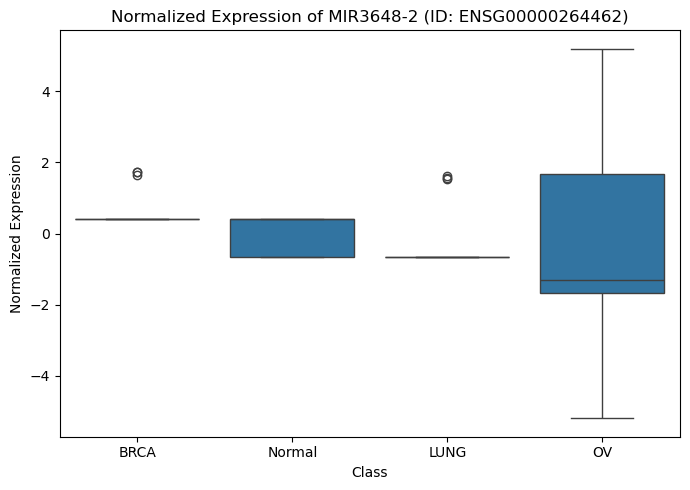

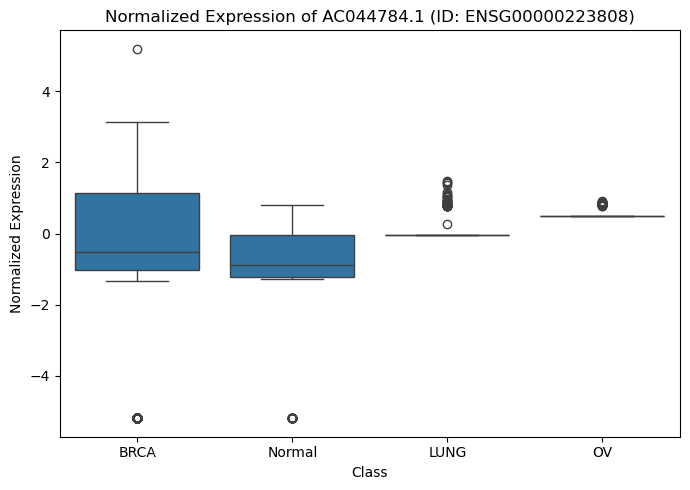

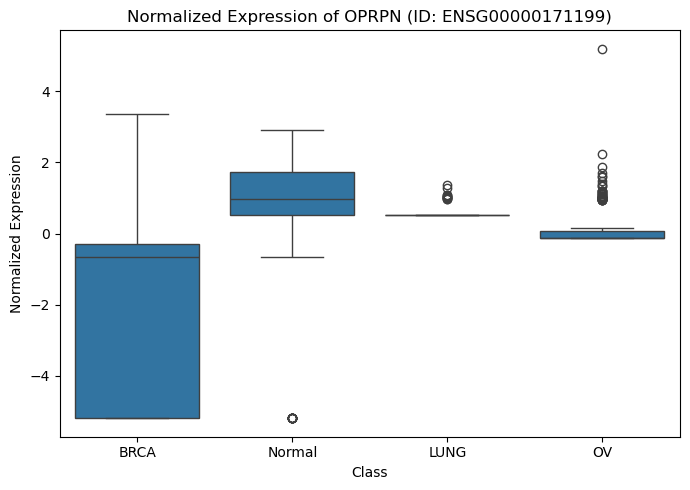

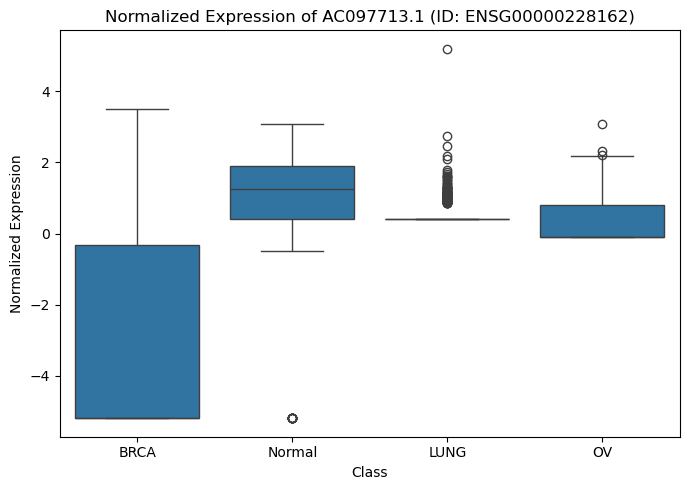

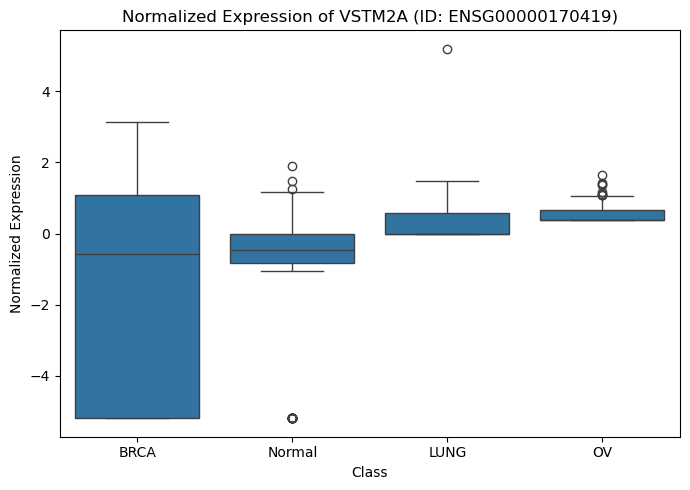


Preparing data for Survival Analysis...
Data ready for survival analysis: 1926 unique cancer patients with survival info.

Running Kaplan-Meier analysis for top gene: MIR3648-2 (ENSG00000264462)...

Log-Rank Test Results:
   test_statistic             p  -log2(p)
0      179.825683  5.290308e-41  133.7957


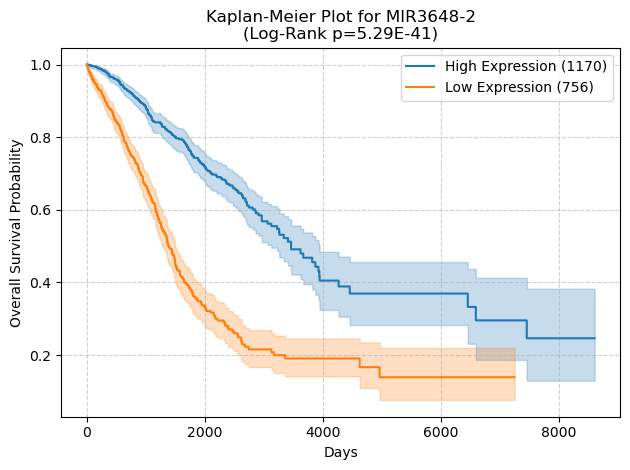


--- Pipeline Finished ---


In [126]:
# ==============================================================================
# Phase 5: Biological Interpretation (Corrected for ID Mismatch)
# ==============================================================================
print("\n--- Starting Phase 5: Biological Interpretation ---")

# --- 5.0: Create Ensembl ID to Gene Name Map ---
id_to_name_map = {}
top_20_gene_names = [] # Initialize
if 'top_20_genes' in locals() and top_20_genes:
    print("Building gene ID-to-Name map...")
    try:
        first_file_id = metadata_df.index[0]
        folder_path = os.path.join(DATA_DIR, first_file_id)
        file_path_glob = os.path.join(folder_path, "*.tsv")
        file_path = glob(file_path_glob)[0]
        gene_map_df = pd.read_csv(file_path, sep="\t", comment='#', header=0, usecols=['gene_id', 'gene_name'])
        gene_map_df = gene_map_df[~gene_map_df['gene_id'].str.startswith('N_', na=False)]
        gene_map_df['stripped_id'] = gene_map_df['gene_id'].str.split('.').str[0]
        id_to_name_map = gene_map_df.set_index('stripped_id')['gene_name'].to_dict()
        top_20_gene_names = [id_to_name_map.get(gid, gid) for gid in top_20_genes]
        top_genes_df = pd.DataFrame({'Ensembl_ID': top_20_genes, 'Gene_Name': top_20_gene_names})
        print("Gene map created successfully.")
        print("\n--- Top 20 Most Important Genes (from SHAP) ---")
        print(top_genes_df)
    except Exception as e:
        print(f"Error creating gene map: {e}")
        top_20_gene_names = top_20_genes
else:
    print("Skipping gene mapping.")
    top_20_gene_names = top_20_genes if 'top_20_genes' in locals() else [] # Ensure it's a list

# --- 5.1: Biomarker Box Plots ---
if 'top_20_genes' in locals() and top_20_genes:
    plot_df_expr = final_data_df.T.copy()
    plot_df_expr['label'] = metadata_df['label'].values
    print("\nGenerating Biomarker Box Plots for Top 5 SHAP genes...")
    plot_order = class_names_in_order
    for (gene_id, gene_name) in zip(top_20_genes[:5], top_20_gene_names[:5]):
        if gene_id in plot_df_expr.columns:
            plt.figure(figsize=(7, 5))
            sns.boxplot(data=plot_df_expr, x='label', y=gene_id, order=plot_order)
            plt.title(f"Normalized Expression of {gene_name} (ID: {gene_id})")
            plt.xlabel("Class")
            plt.ylabel("Normalized Expression")
            plt.tight_layout()
            plt.show()
else:
    print("Skipping Biomarker Box Plots.")

# --- 5.2: Survival Analysis ---
print("\nPreparing data for Survival Analysis...")

# Re-define clinical file paths
CLINICAL_ARCHIVE_FILE = "/Users/medhajha/Downloads/clinical.cart.2025-10-26.tar.gz"
CLINICAL_DIR = os.path.dirname(CLINICAL_ARCHIVE_FILE)
CLINICAL_FILE_TSV = "clinical.tsv"
FOLLOWUP_FILE_TSV = "follow_up.tsv"
CLINICAL_FILE_TSV_PATH = os.path.join(CLINICAL_DIR, CLINICAL_FILE_TSV)
FOLLOWUP_FILE_TSV_PATH = os.path.join(CLINICAL_DIR, FOLLOWUP_FILE_TSV)

try:
    clinical_df = pd.read_csv(CLINICAL_FILE_TSV_PATH, sep="\t", low_memory=False, na_values=["'--", "Not Applicable", "Not Reported"])
    followup_df = pd.read_csv(FOLLOWUP_FILE_TSV_PATH, sep="\t", low_memory=False, na_values=["'--", "Not Applicable", "Not Reported"])
except FileNotFoundError:
    print("ERROR: Could not find clinical/followup files. Skipping Survival Analysis.")
    survival_analysis_ready_df = pd.DataFrame()
except Exception as e:
    print(f"Error reading clinical/followup files: {e}. Skipping.")
    survival_analysis_ready_df = pd.DataFrame()
else:
    # *** FIX: Include 'cases.submitter_id' for merging ***
    clin_cols = ['cases.case_id', 'cases.submitter_id', 'demographic.vital_status', 'demographic.days_to_death', 'diagnoses.days_to_last_follow_up']
    follow_cols = ['cases.case_id', 'follow_ups.days_to_follow_up']
    # ******************************************************
    
    clin_cols_exist = [col for col in clin_cols if col in clinical_df.columns]
    follow_cols_exist = [col for col in follow_cols if col in followup_df.columns]
    
    # Check essential ID columns
    if 'cases.case_id' not in clin_cols_exist or 'cases.case_id' not in follow_cols_exist or 'cases.submitter_id' not in clin_cols_exist:
         print("ERROR: Required ID columns ('cases.case_id', 'cases.submitter_id') missing. Skipping Survival Analysis.")
         survival_analysis_ready_df = pd.DataFrame()
    else:
        # Get base info (including submitter_id) from clinical file
        survival_info = clinical_df[clin_cols_exist].drop_duplicates(subset=['cases.case_id'], keep='first').copy()
        
        # Get latest follow-up info
        if 'follow_ups.days_to_follow_up' in follow_cols_exist:
            followup_data = followup_df[follow_cols_exist].copy()
            followup_data['follow_ups.days_to_follow_up'] = pd.to_numeric(followup_data['follow_ups.days_to_follow_up'], errors='coerce')
            followup_data = followup_data.dropna(subset=['follow_ups.days_to_follow_up'])
            if not followup_data.empty:
                latest_followup = followup_data.loc[followup_data.groupby('cases.case_id')['follow_ups.days_to_follow_up'].idxmax()]
                survival_info = pd.merge(survival_info, latest_followup, on='cases.case_id', how='left')
            else:
                survival_info['follow_ups.days_to_follow_up'] = np.nan
        else:
            survival_info['follow_ups.days_to_follow_up'] = np.nan

        # Calculate T and E
        if 'demographic.vital_status' in survival_info.columns:
            survival_info['demographic.days_to_death'] = pd.to_numeric(survival_info['demographic.days_to_death'], errors='coerce')
            survival_info['followup_days'] = survival_info['follow_ups.days_to_follow_up'].fillna(
                pd.to_numeric(survival_info.get('diagnoses.days_to_last_follow_up'), errors='coerce')
            )
            survival_info['T'] = np.where(
                survival_info['demographic.vital_status'] == 'Dead',
                survival_info['demographic.days_to_death'],
                survival_info['followup_days']
            )
            survival_info['E'] = (survival_info['demographic.vital_status'] == 'Dead').astype(int)
            survival_info = survival_info.dropna(subset=['T', 'E'])
            survival_info = survival_info[survival_info['T'] > 0]
            
            # Merge Expression with Metadata
            expr_with_meta = pd.merge(final_data_df.T, metadata_df, left_index=True, right_index=True, how="inner")

            # *** FIX: Merge using the correct ID pair ***
            # Merge expr_with_meta ('Case ID') with survival_info ('cases.submitter_id')
            survival_analysis_ready_df = pd.merge(
                expr_with_meta,
                survival_info[['cases.submitter_id', 'T', 'E']], # Keep T and E
                left_on="Case ID", # TCGA Barcode from metadata
                right_on="cases.submitter_id", # TCGA Barcode from clinical
                how="inner" # Keep only patients present in both
            )
            # **********************************************

            # Final cleanup
            survival_analysis_ready_df = survival_analysis_ready_df.drop_duplicates(subset=['Case ID']) # Now Case ID is the unique patient identifier
            survival_analysis_ready_df = survival_analysis_ready_df[survival_analysis_ready_df['label'] != 'Normal'].copy()
            print(f"Data ready for survival analysis: {survival_analysis_ready_df.shape[0]} unique cancer patients with survival info.")
        else:
             print("ERROR: 'demographic.vital_status' column not found. Skipping.")
             survival_analysis_ready_df = pd.DataFrame()

    # --- 5.3: Kaplan-Meier Plot for Top Gene ---
    if not survival_analysis_ready_df.empty and 'top_20_genes' in locals() and top_20_genes:
        GENE_ID_TO_TEST = top_20_genes[0]
        GENE_NAME_TO_TEST = top_20_gene_names[0] if top_20_gene_names else GENE_ID_TO_TEST # Fallback name

        if GENE_ID_TO_TEST in survival_analysis_ready_df.columns:
            print(f"\nRunning Kaplan-Meier analysis for top gene: {GENE_NAME_TO_TEST} ({GENE_ID_TO_TEST})...")
            median_expr = survival_analysis_ready_df[GENE_ID_TO_TEST].median()
            survival_analysis_ready_df['Group'] = np.where(survival_analysis_ready_df[GENE_ID_TO_TEST] >= median_expr, 'High', 'Low')

            kmf = KaplanMeierFitter()
            ax = plt.subplot(111)
            results = None
            for group_name, group_df in survival_analysis_ready_df.groupby('Group'):
                if not group_df.empty:
                    kmf.fit(group_df['T'], group_df['E'], label=f'{group_name} Expression ({len(group_df)})')
                    kmf.plot_survival_function(ax=ax)

            group_high = survival_analysis_ready_df[survival_analysis_ready_df['Group'] == 'High']
            group_low = survival_analysis_ready_df[survival_analysis_ready_df['Group'] == 'Low']

            if not group_high.empty and not group_low.empty:
                results = logrank_test(group_high['T'], group_low['T'],
                                       event_observed_A=group_high['E'],
                                       event_observed_B=group_low['E'])
                p_value = results.p_value
                plt.title(f"Kaplan-Meier Plot for {GENE_NAME_TO_TEST}\n(Log-Rank p={p_value:.2E})")
                print("\nLog-Rank Test Results:")
                print(results.summary)
            else:
                 plt.title(f"Kaplan-Meier Plot for {GENE_NAME_TO_TEST}\n(Only one group present)")

            plt.xlabel("Days")
            plt.ylabel("Overall Survival Probability")
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: Top gene {GENE_ID_TO_TEST} not found in survival expression data.")
    else:
        print("Skipping Kaplan-Meier plots: No survival data available after filtering or no top genes found.")

print("\n--- Pipeline Finished ---")

In [132]:
# ==============================================================================
# Phase 6: Pathway Analysis (Gene Set Enrichment Analysis) - Corrected
# ==============================================================================
print("\n--- Phase 6: Pathway Analysis ---")

# Ensure gseapy is imported
try:
    import gseapy as gp
except ImportError:
    print("gseapy library not found. Please install it: !pip install gseapy")
    raise ImportError("gseapy not imported.")

# Check if we have the list of top gene names from Phase 5
if 'top_20_gene_names' in locals() and top_20_gene_names:
    print(f"Running enrichment analysis on {len(top_20_gene_names)} genes...")
    
    # Define the gene set libraries to query
    gene_sets_to_query = [
        'GO_Biological_Process_2021',
        'GO_Cellular_Component_2021',
        'GO_Molecular_Function_2021',
        'KEGG_2021_Human'
    ]
    
    try:
        # Run enrichr query (FIXED: removed 'description' argument)
        enr_results = gp.enrichr(gene_list=top_20_gene_names,
                                 gene_sets=gene_sets_to_query,
                                 organism='Human',
                                 outdir='enrichr_results', # Optional: specify output directory
                                 cutoff=0.05 # P-value cutoff for significance
                                )
        
        print("\nEnrichment analysis complete.")
        
        # Display results (top few pathways from each database)
        if enr_results is not None and not enr_results.results.empty:
            print("\n--- Top Enrichment Results (Adjusted P-value < 0.05) ---")
            # Filter for significant results based on Adjusted P-value
            significant_results = enr_results.results[enr_results.results['Adjusted P-value'] < 0.05]
            
            if significant_results.empty:
                 print("No significant enrichment found with the current gene sets and cutoff.")
            else:
                 # Sort by Adjusted P-value
                 significant_results = significant_results.sort_values('Adjusted P-value')
                 
                 # Display top results per gene set library
                 for gene_set_name in gene_sets_to_query:
                     print(f"\nTop results for: {gene_set_name}")
                     top_set_results = significant_results[significant_results['Gene_set'] == gene_set_name].head()
                     if top_set_results.empty:
                         print("  (No significant terms found in this library)")
                     else:
                         # Display relevant columns
                         print(top_set_results[['Term', 'Adjusted P-value', 'Genes']])
                         
                 # Optional: Plot top result
                 try:
                     from gseapy.plot import barplot
                     # Plot the top overall result (lowest adj p-value)
                     top_term_index = significant_results['Adjusted P-value'].idxmin()
                     top_term_data = significant_results.loc[[top_term_index]]

                     if not top_term_data.empty:
                         print("\nGenerating bar plot for the top enriched term...")
                         # Create a temporary file name for the plot
                         plot_filename = "top_enrichment_plot.png"
                         barplot(top_term_data, title=top_term_data['Term'].iloc[0], ofname=plot_filename)
                         print(f"Bar plot saved as {plot_filename}")
                         # Display plot if in interactive environment (like Jupyter)
                         try:
                              from IPython.display import Image, display
                              display(Image(filename=plot_filename))
                         except ImportError:
                              print("Install IPython to display plots directly: !pip install ipython")

                 except ImportError:
                      print("\nNote: Plotting requires gseapy plotting functions (usually included).")
                 except Exception as plot_err:
                      print(f"\nCould not generate enrichment plot: {plot_err}")

        else:
             print("Enrichment analysis did not return results.")
             
    except Exception as e:
        print(f"\nError during enrichment analysis: {e}")
        print("Please ensure you have an active internet connection.")

else:
    print("Could not find the 'top_20_gene_names' list. Please ensure Phase 5 ran successfully.")

print("\n--- Phase 6 Complete ---")


--- Phase 6: Pathway Analysis ---
Running enrichment analysis on 20 genes...

Error during enrichment analysis: Warning: No enrich terms when cutoff = 0.05
Please ensure you have an active internet connection.

--- Phase 6 Complete ---
